# Identify Distinct Fires by DBScan Clustering

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import homogeneity_score, homogeneity_completeness_v_measure
from sklearn.neighbors import NearestNeighbors
# conda install -c conda-forge kneed
from kneed import KneeLocator
from math import radians, cos, sin, asin, sqrt
from sklearn.manifold import TSNE

#Hide the warning messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import data
fire_data = pd.read_csv('fire_data_cleaned.csv')

# check shape and preview
print(f'The data has {fire_data.shape[0]} rows and {fire_data.shape[1]} columns')
fire_data.head()

The data has 252028 rows and 13 columns


,year,month,day,date,acq_time,latitude,longitude,brightness,frp,daynight,confidence,daynight_num,state
0,2001,1,3,2001-01-03,522,33.0145,-105.6639,319.7,23.7,N,99,0,NM
1,2001,1,3,2001-01-03,522,33.0130,-105.6745,319.2,23.2,N,98,0,NM
2,2001,1,3,2001-01-03,522,33.0219,-105.6763,321.1,24.9,N,100,0,NM
3,2001,1,3,2001-01-03,522,33.0307,-105.6781,325.5,30.0,N,100,0,NM
4,2001,1,3,2001-01-03,523,33.4136,-110.8650,321.0,44.4,N,100,0,AZ


In [3]:
# Convert the date into a datetime object
fire_data['datetime'] = pd.to_datetime(fire_data['date'])

# conversion from ns to days. 1 s = 10^9 ns. 1 day = 86400 s.
fire_data['date_int'] = fire_data['datetime'].apply(lambda x: int(x.value/(10**9*86400)))

# shift days to start at min value
day0 = min(fire_data['date_int'])
fire_data['date_int'] = fire_data['date_int'] - day0
print(fire_data['date_int'].unique())

[   0    1    2 ... 7656 7657 7666]


#### Figure out a logical way to scale the space and time data
For the DBScan, we need to find the epsilon parameter to use for clustering. In other words by what radius of space and time do we consider a single fire to occur. 

#### Geographic data
Since latitude and longitude are roughly on the same scale, we will not adjust them independently. 1 degree of latitude is about 69 miles, this does not change with position. 1 degree of longitude at 40 north (about midway through the area we are using) is about 52 miles
ranges from 46 miles at the north end of washington and 58 miles on the south end of the region. We may be able to optimize these distortions a bit better, but for now since the area is reasonably small, we are going to use the raw values. 

#### Comparing the geographic scale to the time scale
Time is measured in days. It would require a very large fire to span one degree of lat/long, however, a single fire can easily span one day.

#### Find out what the average fire size and length are
source: https://sgp.fas.org/crs/misc/IF10244.pdf. 1.6 million wildfires have occurred since 2000. A small percentage of which account for acreage burned. A large fire is 5000 (category G) acres or more which is 7.81 square miles. Since we are mainly concerned with large fires for this analysis, we will use this as an approximation for epsilon. 

source: https://facethefactsusa.org/facts/the-national-burn-rate-is-going-up--literally/#:~:text=Before%201986%2C%20a%20wildfire%20was,photo%20gallery%20includes%20more%20details. The averge length of burn is 8-37 days (increasing over decades). 
   
#### Considering the average size and length
We want something near the scale of ~ 8 miles = ~ 8-37 days

#### Math
 0.1 latitude is about 7 miles (this seems like a decent epsilon in terms of distance)
 0.1 day is 2.4 hours. Scale up the time data so that 0.1 day is about 14 days (~336 hours)
 0.1 days * 100 is 10 days. This is on the lower end of the range, but we may want that so we don't overgroup. 

#### Starting point epsilon
 Let's go with 7 miles and 10 days, epsilon on 0.1

In [4]:
# Scale up so that 0.01 units = 1 day. 0.1 units = 10 days
fire_data['date_int'] = fire_data['date_int']/100
fire_data.info()
print((fire_data['date_int']).unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252028 entries, 0 to 252027
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          252028 non-null  int64         
 1   month         252028 non-null  int64         
 2   day           252028 non-null  int64         
 3   date          252028 non-null  object        
 4   acq_time      252028 non-null  int64         
 5   latitude      252028 non-null  float64       
 6   longitude     252028 non-null  float64       
 7   brightness    252028 non-null  float64       
 8   frp           252028 non-null  float64       
 9   daynight      252028 non-null  object        
 10  confidence    252028 non-null  int64         
 11  daynight_num  252028 non-null  int64         
 12  state         252028 non-null  object        
 13  datetime      252028 non-null  datetime64[ns]
 14  date_int      252028 non-null  float64       
dtypes: datetime64[ns]

In [5]:
# Select the data for the DBscan input
test = fire_data[['latitude', 'longitude', 'date_int']]
test.info()
test.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252028 entries, 0 to 252027
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   latitude   252028 non-null  float64
 1   longitude  252028 non-null  float64
 2   date_int   252028 non-null  float64
dtypes: float64(3)
memory usage: 5.8 MB


,latitude,longitude,date_int
252023,39.9674,-105.2066,76.66
252024,39.9443,-105.1631,76.66
252025,39.9520,-105.1776,76.66
252026,39.9535,-105.1649,76.66
252027,39.9427,-105.1757,76.66


#### Build the DBScan Model

In [6]:
# try changing eps and min_samples
db_model = DBSCAN(eps = 0.1, min_samples = 6)
db_model.fit(test)
y_pred = db_model.fit_predict(test)
test['labels'] = y_pred
test.head()

C:\Users\jenin\AppData\Local\Temp\ipykernel_6864\1822809761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['labels'] = y_pred


,latitude,longitude,date_int,labels
0,33.0145,-105.6639,0.0,-1
1,33.0130,-105.6745,0.0,-1
2,33.0219,-105.6763,0.0,-1
3,33.0307,-105.6781,0.0,-1
4,33.4136,-110.8650,0.0,-1


In [7]:
# get lables and assess the outputs
labels = db_model.labels_
print(list(labels) == list(y_pred))

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

True
Estimated number of clusters: 3355
Estimated number of noise points: 24431


In [8]:
# plotting function for plot consistency
def plot_fires(ax, df, color_by):
    x = df[['longitude']]
    y = df[['latitude']]
    color_by = df.loc[:, color_by]
    ax.scatter(x, y, c=color_by,  marker="o", s = 1, alpha = 0.4, cmap='gist_ncar')

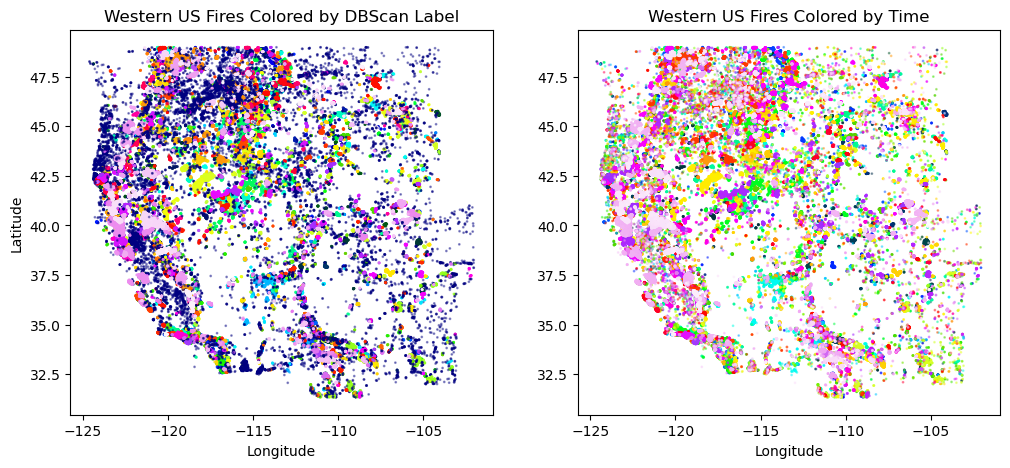

In [9]:
# Plot all data from the DBScan input
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_fires(ax[0], test, 'labels')
plot_fires(ax[1], test, 'date_int')

# Label graph
ax[0].title.set_text('Western US Fires Colored by DBScan Label')
ax[0].set(xlabel="Longitude", ylabel="Latitude")    
ax[1].title.set_text('Western US Fires Colored by Time')
ax[1].set(xlabel = 'Longitude')

# TODO figure out how to add color bar
plt.show()

In [10]:
fire_data['labels']=labels
fire_data.head()

,year,month,day,date,acq_time,latitude,longitude,brightness,frp,daynight,confidence,daynight_num,state,datetime,date_int,labels
0,2001,1,3,2001-01-03,522,33.0145,-105.6639,319.7,23.7,N,99,0,NM,2001-01-03,0.0,-1
1,2001,1,3,2001-01-03,522,33.0130,-105.6745,319.2,23.2,N,98,0,NM,2001-01-03,0.0,-1
2,2001,1,3,2001-01-03,522,33.0219,-105.6763,321.1,24.9,N,100,0,NM,2001-01-03,0.0,-1
3,2001,1,3,2001-01-03,522,33.0307,-105.6781,325.5,30.0,N,100,0,NM,2001-01-03,0.0,-1
4,2001,1,3,2001-01-03,523,33.4136,-110.8650,321.0,44.4,N,100,0,AZ,2001-01-03,0.0,-1


In [11]:
# Dataframe with noise data only
fire_data_noise = fire_data.loc[fire_data['labels'] == -1]

In [12]:
# Dataframe wth clusters only
fire_data_clusters = fire_data.loc[fire_data['labels'] != -1]
fire_data_clusters.head()

,year,month,day,date,acq_time,latitude,longitude,brightness,frp,daynight,confidence,daynight_num,state,datetime,date_int,labels
5,2001,1,3,2001-01-03,1904,32.8294,-116.6631,353.3,93.1,D,97,1,CA,2001-01-03,0.0,0
6,2001,1,3,2001-01-03,1904,32.8289,-116.7179,354.3,95.9,D,97,1,CA,2001-01-03,0.0,0
7,2001,1,3,2001-01-03,1904,32.8266,-116.7048,351.7,87.5,D,96,1,CA,2001-01-03,0.0,0
8,2001,1,3,2001-01-03,1904,32.8219,-116.6785,416.0,510.7,D,100,1,CA,2001-01-03,0.0,0
9,2001,1,3,2001-01-03,1904,32.8196,-116.6660,455.2,1109.6,D,100,1,CA,2001-01-03,0.0,0


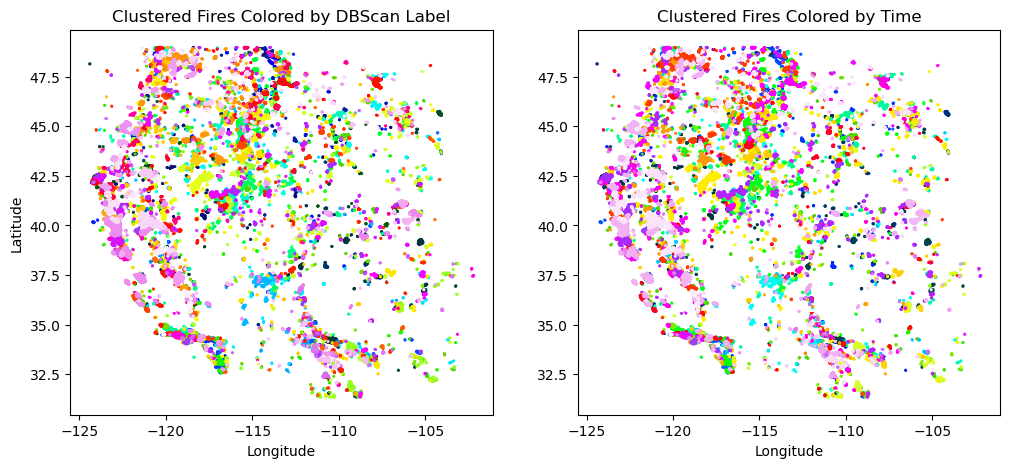

In [13]:
# Plot all data with the noise filtered out
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_fires(ax[0], fire_data_clusters, 'labels')
plot_fires(ax[1], fire_data_clusters, 'date_int')

# Label graph
ax[0].title.set_text('Clustered Fires Colored by DBScan Label')
ax[0].set(xlabel="Longitude", ylabel="Latitude")    
ax[1].title.set_text('Clustered Fires Colored by Time')
ax[1].set(xlabel = 'Longitude')

# TODO figure out how to add color bar
plt.show()

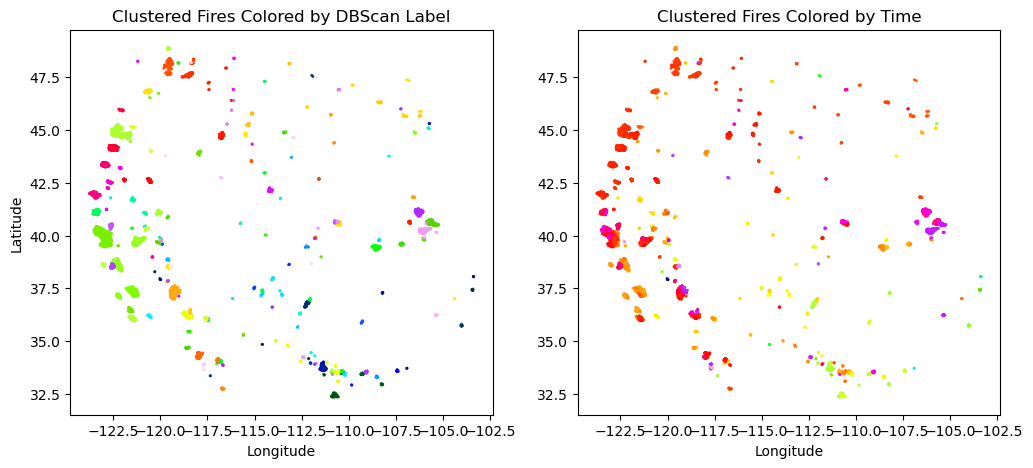

In [14]:
# Plot only clustered data from the DBScan input
fire_clust_2020 = fire_data_clusters.loc[fire_data_clusters['year'] == 2020]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plot_fires(ax[0], fire_clust_2020, 'labels')
plot_fires(ax[1], fire_clust_2020, 'date_int')

# Label graph
ax[0].title.set_text('Clustered Fires Colored by DBScan Label')
ax[0].set(xlabel="Longitude", ylabel="Latitude")    
ax[1].title.set_text('Clustered Fires Colored by Time')
ax[1].set(xlabel = 'Longitude')

# TODO figure out how to add color bar
plt.show()

[0.         0.         0.         ... 2.26134217 2.4629041  2.78718044]


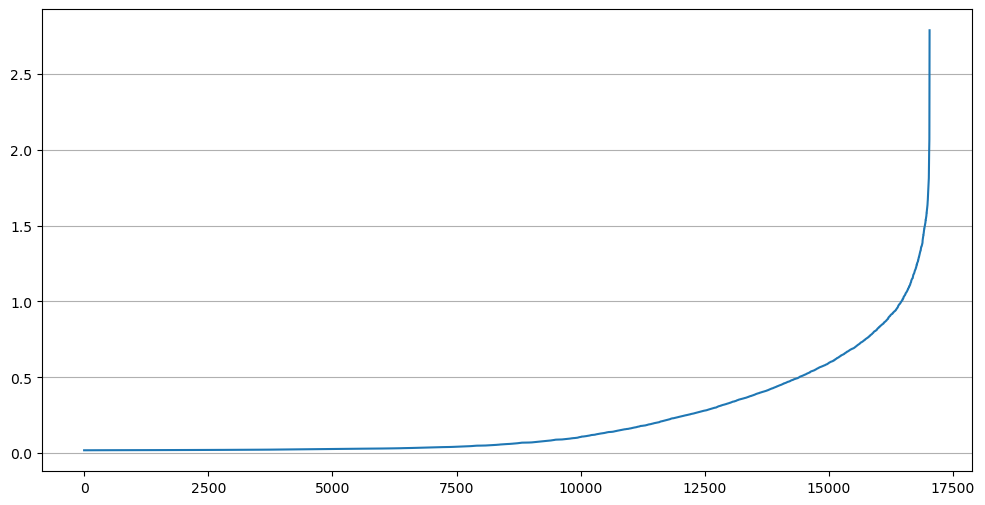

In [15]:
# find the nearest neighbors distances to estimate the optimal epsilon
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(test)
distances, indices = neighbors_fit.kneighbors(test)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
print(distances)
plt.figure(figsize = (12, 6))
plt.plot(distances[235000:])
plt.grid(axis = 'y')

#### Group and describe the data
describe by default will only describe numeric variables

In [16]:
# group the clustered data by label. excludes the noise data (separated above)
fire_grouped = fire_data_clusters.groupby(by=['labels'])
fire_describe = fire_grouped['latitude','longitude','date_int','brightness','frp','year','month'].describe()
fire_describe.head()

latitude                                                                \
          count       mean       std      min        25%       50%        75%   
labels                                                                          
0          20.0  32.799575  0.020089  32.7660  32.788925  32.79865  32.814050   
1           6.0  41.243767  0.006281  41.2349  41.239175  41.24570  41.247875   
2          17.0  39.977447  0.014787  39.9539  39.971900  39.97350  39.986900   
3           8.0  41.312938  0.008868  41.3002  41.308125  41.31290  41.317750   
4          13.0  48.224546  0.010511  48.2113  48.215200  48.22320  48.232600   

                longitude              ...    year         month            \
            max     count        mean  ...     75%     max count mean  std   
labels                                 ...                                   
0       32.8294      20.0 -116.727930  ...  2001.0  2001.0  20.0  1.0  0.0   
1       41.2507       6.0 -120.726817  ...  2001.0  2001.0   6.0  5.0  0.0   
2       40.0067      17.0 -119.672153  ...  2001.0  2001.0  17.0  5.0  0.0   
3       41.3258       8.0 -115.352950  ...  2001.0  2001.0   8.0  7.0  0.0   
4       48.2419      13.0 -120.163877  ...  2001.0  2001.0  13.0  7.0  0.0   

                                 
        min  25%  50%  75%  max  
labels                           
0       1.0  1.0  1.0  1.0  1.0  
1       5.0  5.0  5.0  5.0  5.0  
2       5.0  5.0  5.0  5.0  5.0  
3       7.0  7.0  7.0  7.0  7.0  
4       7.0  7.0  7.0  7.0  7.0  

[5 rows x 56 columns]

In [17]:
# flatten the column names to make it easier to filter
if len(fire_describe.columns[0]) == 2:
    fire_describe.columns = fire_describe.columns.to_series().str.join('_')
    
# The count column is repeated for each variable
if len(fire_describe.columns):
    drop_cols = list(range(0, len(fire_describe.columns)-1, 8))[1:]
    print(drop_cols)
    fire_describe = fire_describe.drop(fire_describe.columns[drop_cols], axis = 1)
    col_count = len(fire_describe.columns)
    
# rename column
if len(fire_describe.columns) == col_count:
    fire_describe = fire_describe.rename(columns={'latitude_count': 'count'})
fire_describe.head()

[8, 16, 24, 32, 40, 48]


,count,latitude_mean,latitude_std,latitude_min,latitude_25%,latitude_50%,latitude_75%,latitude_max,longitude_mean,longitude_std,...,year_50%,year_75%,year_max,month_mean,month_std,month_min,month_25%,month_50%,month_75%,month_max
labels,,,,,,,,,,,,,,,,,,,,,
0,20.0,32.799575,0.020089,32.7660,32.788925,32.79865,32.814050,32.8294,-116.727930,0.052874,...,2001.0,2001.0,2001.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,6.0,41.243767,0.006281,41.2349,41.239175,41.24570,41.247875,41.2507,-120.726817,0.008258,...,2001.0,2001.0,2001.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0
2,17.0,39.977447,0.014787,39.9539,39.971900,39.97350,39.986900,40.0067,-119.672153,0.017581,...,2001.0,2001.0,2001.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0
3,8.0,41.312938,0.008868,41.3002,41.308125,41.31290,41.317750,41.3258,-115.352950,0.052980,...,2001.0,2001.0,2001.0,7.0,0.0,7.0,7.0,7.0,7.0,7.0
4,13.0,48.224546,0.010511,48.2113,48.215200,48.22320,48.232600,48.2419,-120.163877,0.016879,...,2001.0,2001.0,2001.0,7.0,0.0,7.0,7.0,7.0,7.0,7.0


#### Describe the datetime variable

In [18]:
# Get the datetime stats
# get the fire duration in days by substracting first day frm last day
dt_unique = fire_grouped['datetime'].describe()
dt_unique['duration'] =  dt_unique['last'] - dt_unique['first']
dt_unique.head()

,count,unique,top,freq,first,last,duration
labels,,,,,,,
0,20,2,2001-01-03 00:00:00,13,2001-01-03 00:00:00,2001-01-04 00:00:00,1 days
1,6,1,2001-05-21 00:00:00,6,2001-05-21 00:00:00,2001-05-21 00:00:00,0 days
2,17,2,2001-05-27 00:00:00,15,2001-05-25 00:00:00,2001-05-27 00:00:00,2 days
3,8,1,2001-07-05 00:00:00,8,2001-07-05 00:00:00,2001-07-05 00:00:00,0 days
4,13,1,2001-07-10 00:00:00,13,2001-07-10 00:00:00,2001-07-10 00:00:00,0 days


#### Describe the categorical 'state' variable

In [19]:
state_unique = fire_grouped['state'].describe().sort_values(by=['unique'], ascending=False)
print(state_unique['unique'].value_counts())
state_unique.head()

1    3248
2     106
3       1
Name: unique, dtype: int64


,count,unique,top,freq
labels,,,,
275,13,3,CA,9
1483,7,2,AZ,4
682,6,2,CO,5
717,24,2,AZ,15
3158,46,2,CA,38


### Assess the results

Get the range for several attributes to evaluate the spread for all labels.

In [20]:
fire_describe['diff_latitude'] = fire_describe['latitude_max'] - fire_describe['latitude_min']
fire_describe['diff_longitude'] = fire_describe['longitude_max'] - fire_describe['longitude_min']
# convert date back to days for this diff
fire_describe['diff_date'] = (fire_describe['date_int_max'] - fire_describe['date_int_min'])*100
fire_describe['diff_brightness'] = fire_describe['brightness_max'] - fire_describe['brightness_min']
fire_describe['diff_frp'] = fire_describe['frp_max'] - fire_describe['frp_min']
fire_describe['diff_year'] = fire_describe['year_max'] - fire_describe['year_min']
fire_describe['diff_month'] = fire_describe['month_max'] - fire_describe['month_min']
fire_describe.head()

,count,latitude_mean,latitude_std,latitude_min,latitude_25%,latitude_50%,latitude_75%,latitude_max,longitude_mean,longitude_std,...,month_50%,month_75%,month_max,diff_latitude,diff_longitude,diff_date,diff_brightness,diff_frp,diff_year,diff_month
labels,,,,,,,,,,,,,,,,,,,,,
0,20.0,32.799575,0.020089,32.7660,32.788925,32.79865,32.814050,32.8294,-116.727930,0.052874,...,1.0,1.0,1.0,0.0634,0.1557,1.0,178.7,2262.4,0.0,0.0
1,6.0,41.243767,0.006281,41.2349,41.239175,41.24570,41.247875,41.2507,-120.726817,0.008258,...,5.0,5.0,5.0,0.0158,0.0209,0.0,34.3,109.6,0.0,0.0
2,17.0,39.977447,0.014787,39.9539,39.971900,39.97350,39.986900,40.0067,-119.672153,0.017581,...,5.0,5.0,5.0,0.0528,0.0533,2.0,92.7,976.1,0.0,0.0
3,8.0,41.312938,0.008868,41.3002,41.308125,41.31290,41.317750,41.3258,-115.352950,0.052980,...,7.0,7.0,7.0,0.0256,0.1157,0.0,77.0,600.7,0.0,0.0
4,13.0,48.224546,0.010511,48.2113,48.215200,48.22320,48.232600,48.2419,-120.163877,0.016879,...,7.0,7.0,7.0,0.0306,0.0549,0.0,44.1,93.8,0.0,0.0


What is the distribution of the data? We expect the within cluster distributions to be small. The following boxplots are plotting the distribution of the statistic values for all clusters. 

<Axes: >

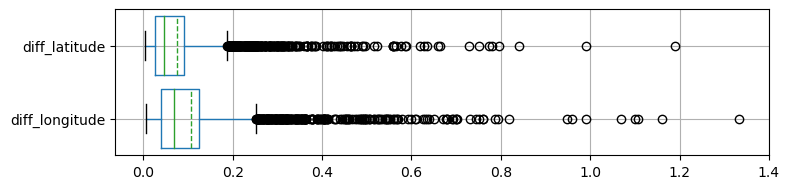

In [21]:
# Set the figure size
plt.rcParams["figure.figsize"] = [8, 2]
plt.rcParams["figure.autolayout"] = True

# Select variables to plot
data = fire_describe[['diff_longitude','diff_latitude']]
data.boxplot(meanline=True, showmeans=True, vert=False, widths = 0.8)

<Axes: >

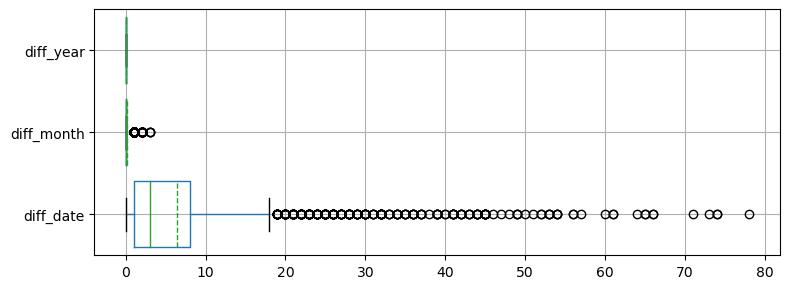

In [22]:
# Set the figure size
plt.rcParams["figure.figsize"] = [8, 3]
plt.rcParams["figure.autolayout"] = True

# Select variables to plot
data = fire_describe[['diff_date', 'diff_month','diff_year']]
data.boxplot(meanline=True, showmeans=True, vert=False, widths = 0.8)


<Axes: >

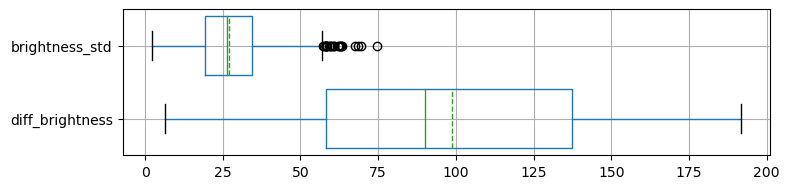

In [23]:
# Set the figure size
plt.rcParams["figure.figsize"] = [8, 2]
plt.rcParams["figure.autolayout"] = True

# Select variables to plot
data = fire_describe[['diff_brightness', 'brightness_std']]
data.boxplot(meanline=True, showmeans=True, vert=False, widths = 0.8)


<Axes: >

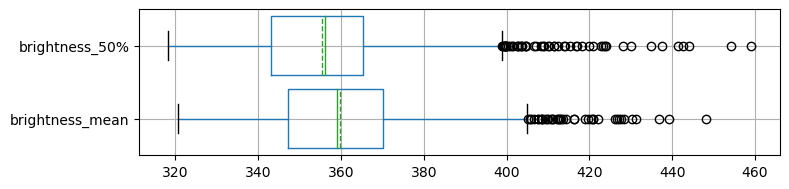

In [24]:
# Set the figure size
plt.rcParams["figure.figsize"] = [8, 2]
plt.rcParams["figure.autolayout"] = True

# Select variables to plot
data = fire_describe[['brightness_mean','brightness_50%']]
data.boxplot(meanline=True, showmeans=True, vert=False, widths = 0.8)

<Axes: >

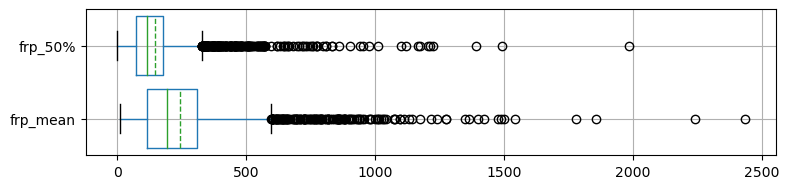

In [25]:
# Set the figure size
plt.rcParams["figure.figsize"] = [8, 2]
plt.rcParams["figure.autolayout"] = True

# Select variables to plot
data = fire_describe[['frp_mean','frp_50%']]
data.boxplot(meanline=True, showmeans=True, vert=False, widths = 0.8)

<Axes: >

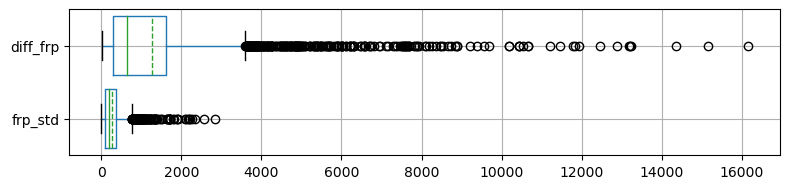

In [26]:
# Set the figure size
plt.rcParams["figure.figsize"] = [8, 2]
plt.rcParams["figure.autolayout"] = True

# Select variables to plot
data = fire_describe[['frp_std','diff_frp']]
data.boxplot(meanline=True, showmeans=True, vert=False, widths = 0.8)

<Axes: >

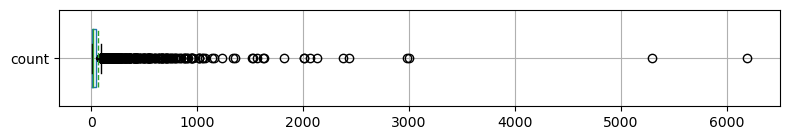

In [27]:
# Set the figure size
plt.rcParams["figure.figsize"] = [8, 1.5]
plt.rcParams["figure.autolayout"] = True

# Select variables to plot
data = fire_describe[['count']]
data.boxplot(meanline=True, showmeans=True, vert=False, widths = 0.6)

How many states are in each fire cluster? We expect this to be 1 for the vast majority of data, however, it is possible for a single fire to border state lines. 

In [28]:
# All fire clusters that span more than one state
two_states = state_unique[['unique', 'top']].loc[state_unique['unique']>=2].sort_values('unique', ascending = False)
print(two_states.value_counts())
two_states.head()

unique  top
2       ID     22
        NV     15
        AZ     14
        MT     13
        CA     10
        WY      9
        OR      7
        CO      5
        NM      5
        UT      5
        WA      1
3       CA      1
dtype: int64


,unique,top
labels,,
275,3,CA
3032,2,MT
336,2,WY
2773,2,MT
322,2,ID


In [29]:
# Print out the states that are in each fire that occurs in more than one state to ensure they are bordering. 
g = fire_grouped['state'].apply(lambda x: list(np.unique(x)))

h = []
for i in g:
    if (len(i) >1) & (i not in h):
        h.append(i)
        
print(h)

[['CA', 'NV'], ['CO', 'NM'], ['NV', 'UT'], ['CO', 'UT'], ['CA', 'OR'], ['AZ', 'CA'], ['AZ', 'NM'], ['ID', 'MT'], ['AZ', 'CA', 'NV'], ['MT', 'WY'], ['ID', 'WA'], ['OR', 'WA'], ['ID', 'NV'], ['ID', 'OR'], ['NV', 'OR'], ['ID', 'UT'], ['CO', 'WY'], ['UT', 'WY'], ['AZ', 'UT'], ['AZ', 'NV']]


#### DBScan Data Output

In [30]:
# List of attributes we want in the output
    # top_state, state_list
cols = ['count', 'diff_date', 'year_50%', 'month_50%',
        'latitude_mean', 'latitude_50%', 'diff_latitude', 
        'longitude_mean', 'longitude_50%', 'diff_longitude', 
        'brightness_mean', 'brightness_50%', 'brightness_std', 
        'frp_mean', 'frp_50%', 'frp_std']
fire_DBscan = fire_describe[cols]    
fire_DBscan.head()

,count,diff_date,year_50%,month_50%,latitude_mean,latitude_50%,diff_latitude,longitude_mean,longitude_50%,diff_longitude,brightness_mean,brightness_50%,brightness_std,frp_mean,frp_50%,frp_std
labels,,,,,,,,,,,,,,,,
0,20.0,1.0,2001.0,1.0,32.799575,32.79865,0.0634,-116.727930,-116.71085,0.1557,386.600000,366.25,50.501141,426.855000,125.70,590.605047
1,6.0,0.0,2001.0,5.0,41.243767,41.24570,0.0158,-120.726817,-120.72670,0.0209,353.383333,356.55,12.752320,98.800000,103.65,39.875406
2,17.0,2.0,2001.0,5.0,39.977447,39.97350,0.0528,-119.672153,-119.66540,0.0533,357.070588,346.60,25.500043,306.735294,207.60,270.417968
3,8.0,0.0,2001.0,7.0,41.312938,41.31290,0.0256,-115.352950,-115.35310,0.1157,378.175000,367.30,24.575525,211.787500,123.00,197.392846
4,13.0,0.0,2001.0,7.0,48.224546,48.22320,0.0306,-120.163877,-120.16620,0.0549,336.876923,335.00,14.356308,48.800000,42.80,28.906343


#### For each fire, find the nearest air quality sensor

In [31]:
air_quality_data = pd.read_csv('air_quality_data_cleaned.csv')
air_quality_data.head()

,year,month,day,date,state,SITE_LATITUDE,SITE_LONGITUDE,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE,PERCENT_COMPLETE
0,2001,1,13,2001-01-13,AZ,34.058475,-109.441259,0.8,3,100.0
1,2001,1,16,2001-01-16,AZ,34.058475,-109.441259,1.7,7,100.0
2,2001,2,21,2001-02-21,AZ,34.058475,-109.441259,1.3,5,100.0
3,2001,2,24,2001-02-24,AZ,34.058475,-109.441259,1.6,7,100.0
4,2001,2,27,2001-02-27,AZ,34.058475,-109.441259,2.1,9,100.0


In [32]:
new_air_quality_data = air_quality_data.drop(columns =['year', 'month', 'day', 'PERCENT_COMPLETE'])
new_air_quality_data.head()

,date,state,SITE_LATITUDE,SITE_LONGITUDE,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE
0,2001-01-13,AZ,34.058475,-109.441259,0.8,3
1,2001-01-16,AZ,34.058475,-109.441259,1.7,7
2,2001-02-21,AZ,34.058475,-109.441259,1.3,5
3,2001-02-24,AZ,34.058475,-109.441259,1.6,7
4,2001-02-27,AZ,34.058475,-109.441259,2.1,9


In [33]:
print(new_air_quality_data.dtypes)

date                               object
state                              object
SITE_LATITUDE                     float64
SITE_LONGITUDE                    float64
Daily Mean PM2.5 Concentration    float64
DAILY_AQI_VALUE                     int64
dtype: object


In [34]:
print(new_air_quality_data.shape)

(2403146, 6)


In [35]:
aq_sensors = air_quality_data.loc[:, ['SITE_LATITUDE', 'SITE_LONGITUDE']].drop_duplicates().reset_index(drop = True)
print(len(aq_sensors))
aq_sensors.head()

842


,SITE_LATITUDE,SITE_LONGITUDE
0,34.058475,-109.441259
1,31.349200,-109.539683
2,32.009410,-109.389060
3,35.206111,-111.652777
4,36.077814,-112.129551


In [36]:
# Find the nearest monitor by distance in the file ‘air_quality_data_cleaned.csv’ to each fire cluster
# https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546

# Define function dist
def dist(lat1, long1, lat2, long2):
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def nearest_monitor(df_aq, lat, long):
    distances = df_aq.apply(lambda row: dist(lat, long, row['SITE_LATITUDE'], row['SITE_LONGITUDE']), axis=1)
    return ((df_aq.loc[distances.idxmin(), 'SITE_LATITUDE']), (df_aq.loc[distances.idxmin(), 'SITE_LONGITUDE']))

def add_to_fire_data(fire_df, aq_df):
    fire_df['nearest_aq_monitor'] = fire_df.apply(lambda row: nearest_monitor(aq_df, row['latitude_50%'], 
                                                                              row['longitude_50%']), axis = 1)
    return fire_df

In [37]:
# Find the nearest monitor by distance to each fire cluster 'center'
# add long, lat tuple to fire dataframe
monitor_test = add_to_fire_data(fire_DBscan, aq_sensors)
monitor_test.tail()

C:\Users\jenin\AppData\Local\Temp\ipykernel_6864\882762132.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_df['nearest_aq_monitor'] = fire_df.apply(lambda row: nearest_monitor(aq_df, row['latitude_50%'],


,count,diff_date,year_50%,month_50%,latitude_mean,latitude_50%,diff_latitude,longitude_mean,longitude_50%,diff_longitude,brightness_mean,brightness_50%,brightness_std,frp_mean,frp_50%,frp_std,nearest_aq_monitor
labels,,,,,,,,,,,,,,,,,
3350,6.0,0.0,2021.0,11.0,46.516117,46.51575,0.0176,-116.127367,-116.13040,0.0172,367.033333,364.15,13.218119,122.266667,108.2,44.909761,"(46.2094, -116.0275)"
3351,11.0,0.0,2021.0,11.0,47.220409,47.20470,0.0938,-116.782527,-116.78250,0.0223,361.627273,363.70,13.265526,100.800000,98.8,39.680247,"(47.338604592, -116.885623481)"
3352,7.0,5.0,2021.0,11.0,34.456900,34.44220,0.0738,-112.462243,-112.46250,0.0297,376.242857,365.10,30.152936,225.728571,226.9,127.656397,"(34.595, -112.331)"
3353,7.0,0.0,2021.0,11.0,36.764343,36.76560,0.0271,-105.076971,-105.07740,0.0307,376.357143,368.10,19.365851,181.414286,130.3,101.184426,"(36.5854402544904, -105.452562505288)"
3354,6.0,0.0,2021.0,12.0,39.954283,39.95275,0.0247,-105.184500,-105.17665,0.0560,388.750000,373.40,56.008419,398.733333,157.9,646.941001,"(40.0210970009293, -105.263382)"


#### Additional evaluation of clustering

In [38]:
fire_attributes = pd.merge(monitor_test, state_unique, how='inner', on='labels')

In [39]:
fire_attributes = pd.merge(fire_attributes, dt_unique, how='left', on='labels' )

In [40]:
fire_attributes

,count_x,diff_date,year_50%,month_50%,latitude_mean,latitude_50%,diff_latitude,longitude_mean,longitude_50%,diff_longitude,...,unique_x,top_x,freq_x,count,unique_y,top_y,freq_y,first,last,duration
labels,,,,,,,,,,,,,,,,,,,,,
0,20.0,1.0,2001.0,1.0,32.799575,32.79865,0.0634,-116.727930,-116.71085,0.1557,...,1,CA,20,20,2,2001-01-03 00:00:00,13,2001-01-03 00:00:00,2001-01-04 00:00:00,1 days
1,6.0,0.0,2001.0,5.0,41.243767,41.24570,0.0158,-120.726817,-120.72670,0.0209,...,1,CA,6,6,1,2001-05-21 00:00:00,6,2001-05-21 00:00:00,2001-05-21 00:00:00,0 days
2,17.0,2.0,2001.0,5.0,39.977447,39.97350,0.0528,-119.672153,-119.66540,0.0533,...,1,NV,17,17,2,2001-05-27 00:00:00,15,2001-05-25 00:00:00,2001-05-27 00:00:00,2 days
3,8.0,0.0,2001.0,7.0,41.312938,41.31290,0.0256,-115.352950,-115.35310,0.1157,...,1,NV,8,8,1,2001-07-05 00:00:00,8,2001-07-05 00:00:00,2001-07-05 00:00:00,0 days
4,13.0,0.0,2001.0,7.0,48.224546,48.22320,0.0306,-120.163877,-120.16620,0.0549,...,1,WA,13,13,1,2001-07-10 00:00:00,13,2001-07-10 00:00:00,2001-07-10 00:00:00,0 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350,6.0,0.0,2021.0,11.0,46.516117,46.51575,0.0176,-116.127367,-116.13040,0.0172,...,1,ID,6,6,1,2021-11-08 00:00:00,6,2021-11-08 00:00:00,2021-11-08 00:00:00,0 days
3351,11.0,0.0,2021.0,11.0,47.220409,47.20470,0.0938,-116.782527,-116.78250,0.0223,...,1,ID,11,11,1,2021-11-08 00:00:00,11,2021-11-08 00:00:00,2021-11-08 00:00:00,0 days
3352,7.0,5.0,2021.0,11.0,34.456900,34.44220,0.0738,-112.462243,-112.46250,0.0297,...,1,AZ,7,7,3,2021-11-13 00:00:00,3,2021-11-08 00:00:00,2021-11-13 00:00:00,5 days


In [41]:
fire_attributes = fire_attributes.drop(columns =['freq_x', 'count', 'freq_y', 'unique_y',
                                                'count_y','top_y','duration'])
fire_attributes.head()

,count_x,diff_date,year_50%,month_50%,latitude_mean,latitude_50%,diff_latitude,longitude_mean,longitude_50%,diff_longitude,...,brightness_50%,brightness_std,frp_mean,frp_50%,frp_std,nearest_aq_monitor,unique_x,top_x,first,last
labels,,,,,,,,,,,,,,,,,,,,,
0,20.0,1.0,2001.0,1.0,32.799575,32.79865,0.0634,-116.727930,-116.71085,0.1557,...,366.25,50.501141,426.855000,125.70,590.605047,"(32.8423180008601, -116.768293)",1,CA,2001-01-03 00:00:00,2001-01-04 00:00:00
1,6.0,0.0,2001.0,5.0,41.243767,41.24570,0.0158,-120.726817,-120.72670,0.0209,...,356.55,12.752320,98.800000,103.65,39.875406,"(41.483225471, -120.54023355)",1,CA,2001-05-21 00:00:00,2001-05-21 00:00:00
2,17.0,2.0,2001.0,5.0,39.977447,39.97350,0.0528,-119.672153,-119.66540,0.0533,...,346.60,25.500043,306.735294,207.60,270.417968,"(39.621434, -119.71877)",1,NV,2001-05-25 00:00:00,2001-05-27 00:00:00
3,8.0,0.0,2001.0,7.0,41.312938,41.31290,0.0256,-115.352950,-115.35310,0.1157,...,367.30,24.575525,211.787500,123.00,197.392846,"(41.8924989934688, -115.427014818654)",1,NV,2001-07-05 00:00:00,2001-07-05 00:00:00
4,13.0,0.0,2001.0,7.0,48.224546,48.22320,0.0306,-120.163877,-120.16620,0.0549,...,335.00,14.356308,48.800000,42.80,28.906343,"(48.354124, -120.105116)",1,WA,2001-07-10 00:00:00,2001-07-10 00:00:00


In [42]:
fire_attributes.rename(columns={'count_x':'count', 'diff_date': '#_days','unique_x': 'state_count','top_x': 'top_state',
                               'first':'first_day','last':'last_day'}, inplace = True)

fire_attributes.head()

,count,#_days,year_50%,month_50%,latitude_mean,latitude_50%,diff_latitude,longitude_mean,longitude_50%,diff_longitude,...,brightness_50%,brightness_std,frp_mean,frp_50%,frp_std,nearest_aq_monitor,state_count,top_state,first_day,last_day
labels,,,,,,,,,,,,,,,,,,,,,
0,20.0,1.0,2001.0,1.0,32.799575,32.79865,0.0634,-116.727930,-116.71085,0.1557,...,366.25,50.501141,426.855000,125.70,590.605047,"(32.8423180008601, -116.768293)",1,CA,2001-01-03 00:00:00,2001-01-04 00:00:00
1,6.0,0.0,2001.0,5.0,41.243767,41.24570,0.0158,-120.726817,-120.72670,0.0209,...,356.55,12.752320,98.800000,103.65,39.875406,"(41.483225471, -120.54023355)",1,CA,2001-05-21 00:00:00,2001-05-21 00:00:00
2,17.0,2.0,2001.0,5.0,39.977447,39.97350,0.0528,-119.672153,-119.66540,0.0533,...,346.60,25.500043,306.735294,207.60,270.417968,"(39.621434, -119.71877)",1,NV,2001-05-25 00:00:00,2001-05-27 00:00:00
3,8.0,0.0,2001.0,7.0,41.312938,41.31290,0.0256,-115.352950,-115.35310,0.1157,...,367.30,24.575525,211.787500,123.00,197.392846,"(41.8924989934688, -115.427014818654)",1,NV,2001-07-05 00:00:00,2001-07-05 00:00:00
4,13.0,0.0,2001.0,7.0,48.224546,48.22320,0.0306,-120.163877,-120.16620,0.0549,...,335.00,14.356308,48.800000,42.80,28.906343,"(48.354124, -120.105116)",1,WA,2001-07-10 00:00:00,2001-07-10 00:00:00


In [43]:
fire_attributes.columns

Index(['count', '#_days', 'year_50%', 'month_50%', 'latitude_mean',
       'latitude_50%', 'diff_latitude', 'longitude_mean', 'longitude_50%',
       'diff_longitude', 'brightness_mean', 'brightness_50%', 'brightness_std',
       'frp_mean', 'frp_50%', 'frp_std', 'nearest_aq_monitor', 'state_count',
       'top_state', 'first_day', 'last_day'],
      dtype='object')

In [44]:
fire_attributes = fire_attributes[['count','state_count','top_state','first_day','last_day','#_days','year_50%','month_50%',
                                   'latitude_mean','latitude_50%', 'diff_latitude', 'longitude_mean', 'longitude_50%',
                                   'diff_longitude', 'brightness_mean', 'brightness_50%', 'brightness_std','frp_mean',
                                   'frp_50%', 'frp_std', 'nearest_aq_monitor']]
fire_attributes.head()

,count,state_count,top_state,first_day,last_day,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,longitude_mean,longitude_50%,diff_longitude,brightness_mean,brightness_50%,brightness_std,frp_mean,frp_50%,frp_std,nearest_aq_monitor
labels,,,,,,,,,,,,,,,,,,,,,
0,20.0,1,CA,2001-01-03 00:00:00,2001-01-04 00:00:00,1.0,2001.0,1.0,32.799575,32.79865,...,-116.727930,-116.71085,0.1557,386.600000,366.25,50.501141,426.855000,125.70,590.605047,"(32.8423180008601, -116.768293)"
1,6.0,1,CA,2001-05-21 00:00:00,2001-05-21 00:00:00,0.0,2001.0,5.0,41.243767,41.24570,...,-120.726817,-120.72670,0.0209,353.383333,356.55,12.752320,98.800000,103.65,39.875406,"(41.483225471, -120.54023355)"
2,17.0,1,NV,2001-05-25 00:00:00,2001-05-27 00:00:00,2.0,2001.0,5.0,39.977447,39.97350,...,-119.672153,-119.66540,0.0533,357.070588,346.60,25.500043,306.735294,207.60,270.417968,"(39.621434, -119.71877)"
3,8.0,1,NV,2001-07-05 00:00:00,2001-07-05 00:00:00,0.0,2001.0,7.0,41.312938,41.31290,...,-115.352950,-115.35310,0.1157,378.175000,367.30,24.575525,211.787500,123.00,197.392846,"(41.8924989934688, -115.427014818654)"
4,13.0,1,WA,2001-07-10 00:00:00,2001-07-10 00:00:00,0.0,2001.0,7.0,48.224546,48.22320,...,-120.163877,-120.16620,0.0549,336.876923,335.00,14.356308,48.800000,42.80,28.906343,"(48.354124, -120.105116)"


In [45]:
# 
fire_attributes['#_days'] = fire_attributes['#_days'] + 1
fire_attributes.head()

,count,state_count,top_state,first_day,last_day,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,longitude_mean,longitude_50%,diff_longitude,brightness_mean,brightness_50%,brightness_std,frp_mean,frp_50%,frp_std,nearest_aq_monitor
labels,,,,,,,,,,,,,,,,,,,,,
0,20.0,1,CA,2001-01-03 00:00:00,2001-01-04 00:00:00,2.0,2001.0,1.0,32.799575,32.79865,...,-116.727930,-116.71085,0.1557,386.600000,366.25,50.501141,426.855000,125.70,590.605047,"(32.8423180008601, -116.768293)"
1,6.0,1,CA,2001-05-21 00:00:00,2001-05-21 00:00:00,1.0,2001.0,5.0,41.243767,41.24570,...,-120.726817,-120.72670,0.0209,353.383333,356.55,12.752320,98.800000,103.65,39.875406,"(41.483225471, -120.54023355)"
2,17.0,1,NV,2001-05-25 00:00:00,2001-05-27 00:00:00,3.0,2001.0,5.0,39.977447,39.97350,...,-119.672153,-119.66540,0.0533,357.070588,346.60,25.500043,306.735294,207.60,270.417968,"(39.621434, -119.71877)"
3,8.0,1,NV,2001-07-05 00:00:00,2001-07-05 00:00:00,1.0,2001.0,7.0,41.312938,41.31290,...,-115.352950,-115.35310,0.1157,378.175000,367.30,24.575525,211.787500,123.00,197.392846,"(41.8924989934688, -115.427014818654)"
4,13.0,1,WA,2001-07-10 00:00:00,2001-07-10 00:00:00,1.0,2001.0,7.0,48.224546,48.22320,...,-120.163877,-120.16620,0.0549,336.876923,335.00,14.356308,48.800000,42.80,28.906343,"(48.354124, -120.105116)"


In [46]:
fire_attributes = fire_attributes.astype({'count':'int', '#_days':'int', 'year_50%':'int', 'month_50%':'int'}) 
fire_attributes.head()

,count,state_count,top_state,first_day,last_day,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,longitude_mean,longitude_50%,diff_longitude,brightness_mean,brightness_50%,brightness_std,frp_mean,frp_50%,frp_std,nearest_aq_monitor
labels,,,,,,,,,,,,,,,,,,,,,
0,20,1,CA,2001-01-03 00:00:00,2001-01-04 00:00:00,2,2001,1,32.799575,32.79865,...,-116.727930,-116.71085,0.1557,386.600000,366.25,50.501141,426.855000,125.70,590.605047,"(32.8423180008601, -116.768293)"
1,6,1,CA,2001-05-21 00:00:00,2001-05-21 00:00:00,1,2001,5,41.243767,41.24570,...,-120.726817,-120.72670,0.0209,353.383333,356.55,12.752320,98.800000,103.65,39.875406,"(41.483225471, -120.54023355)"
2,17,1,NV,2001-05-25 00:00:00,2001-05-27 00:00:00,3,2001,5,39.977447,39.97350,...,-119.672153,-119.66540,0.0533,357.070588,346.60,25.500043,306.735294,207.60,270.417968,"(39.621434, -119.71877)"
3,8,1,NV,2001-07-05 00:00:00,2001-07-05 00:00:00,1,2001,7,41.312938,41.31290,...,-115.352950,-115.35310,0.1157,378.175000,367.30,24.575525,211.787500,123.00,197.392846,"(41.8924989934688, -115.427014818654)"
4,13,1,WA,2001-07-10 00:00:00,2001-07-10 00:00:00,1,2001,7,48.224546,48.22320,...,-120.163877,-120.16620,0.0549,336.876923,335.00,14.356308,48.800000,42.80,28.906343,"(48.354124, -120.105116)"


In [47]:
type(fire_attributes['nearest_aq_monitor'][0][0])


numpy.float64

In [48]:
fire_attributes['aq_latitude'] = fire_attributes['nearest_aq_monitor'].apply(lambda x:x[0]).values
fire_attributes

,count,state_count,top_state,first_day,last_day,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,longitude_50%,diff_longitude,brightness_mean,brightness_50%,brightness_std,frp_mean,frp_50%,frp_std,nearest_aq_monitor,aq_latitude
labels,,,,,,,,,,,,,,,,,,,,,
0,20,1,CA,2001-01-03 00:00:00,2001-01-04 00:00:00,2,2001,1,32.799575,32.79865,...,-116.71085,0.1557,386.600000,366.25,50.501141,426.855000,125.70,590.605047,"(32.8423180008601, -116.768293)",32.842318
1,6,1,CA,2001-05-21 00:00:00,2001-05-21 00:00:00,1,2001,5,41.243767,41.24570,...,-120.72670,0.0209,353.383333,356.55,12.752320,98.800000,103.65,39.875406,"(41.483225471, -120.54023355)",41.483225
2,17,1,NV,2001-05-25 00:00:00,2001-05-27 00:00:00,3,2001,5,39.977447,39.97350,...,-119.66540,0.0533,357.070588,346.60,25.500043,306.735294,207.60,270.417968,"(39.621434, -119.71877)",39.621434
3,8,1,NV,2001-07-05 00:00:00,2001-07-05 00:00:00,1,2001,7,41.312938,41.31290,...,-115.35310,0.1157,378.175000,367.30,24.575525,211.787500,123.00,197.392846,"(41.8924989934688, -115.427014818654)",41.892499
4,13,1,WA,2001-07-10 00:00:00,2001-07-10 00:00:00,1,2001,7,48.224546,48.22320,...,-120.16620,0.0549,336.876923,335.00,14.356308,48.800000,42.80,28.906343,"(48.354124, -120.105116)",48.354124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350,6,1,ID,2021-11-08 00:00:00,2021-11-08 00:00:00,1,2021,11,46.516117,46.51575,...,-116.13040,0.0172,367.033333,364.15,13.218119,122.266667,108.20,44.909761,"(46.2094, -116.0275)",46.209400
3351,11,1,ID,2021-11-08 00:00:00,2021-11-08 00:00:00,1,2021,11,47.220409,47.20470,...,-116.78250,0.0223,361.627273,363.70,13.265526,100.800000,98.80,39.680247,"(47.338604592, -116.885623481)",47.338605
3352,7,1,AZ,2021-11-08 00:00:00,2021-11-13 00:00:00,5,2021,11,34.456900,34.44220,...,-112.46250,0.0297,376.242857,365.10,30.152936,225.728571,226.90,127.656397,"(34.595, -112.331)",34.595000


In [49]:
fire_attributes['aq_longitude'] = fire_attributes['nearest_aq_monitor'].apply(lambda x:x[1]).values
fire_attributes

,count,state_count,top_state,first_day,last_day,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,diff_longitude,brightness_mean,brightness_50%,brightness_std,frp_mean,frp_50%,frp_std,nearest_aq_monitor,aq_latitude,aq_longitude
labels,,,,,,,,,,,,,,,,,,,,,
0,20,1,CA,2001-01-03 00:00:00,2001-01-04 00:00:00,2,2001,1,32.799575,32.79865,...,0.1557,386.600000,366.25,50.501141,426.855000,125.70,590.605047,"(32.8423180008601, -116.768293)",32.842318,-116.768293
1,6,1,CA,2001-05-21 00:00:00,2001-05-21 00:00:00,1,2001,5,41.243767,41.24570,...,0.0209,353.383333,356.55,12.752320,98.800000,103.65,39.875406,"(41.483225471, -120.54023355)",41.483225,-120.540234
2,17,1,NV,2001-05-25 00:00:00,2001-05-27 00:00:00,3,2001,5,39.977447,39.97350,...,0.0533,357.070588,346.60,25.500043,306.735294,207.60,270.417968,"(39.621434, -119.71877)",39.621434,-119.718770
3,8,1,NV,2001-07-05 00:00:00,2001-07-05 00:00:00,1,2001,7,41.312938,41.31290,...,0.1157,378.175000,367.30,24.575525,211.787500,123.00,197.392846,"(41.8924989934688, -115.427014818654)",41.892499,-115.427015
4,13,1,WA,2001-07-10 00:00:00,2001-07-10 00:00:00,1,2001,7,48.224546,48.22320,...,0.0549,336.876923,335.00,14.356308,48.800000,42.80,28.906343,"(48.354124, -120.105116)",48.354124,-120.105116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350,6,1,ID,2021-11-08 00:00:00,2021-11-08 00:00:00,1,2021,11,46.516117,46.51575,...,0.0172,367.033333,364.15,13.218119,122.266667,108.20,44.909761,"(46.2094, -116.0275)",46.209400,-116.027500
3351,11,1,ID,2021-11-08 00:00:00,2021-11-08 00:00:00,1,2021,11,47.220409,47.20470,...,0.0223,361.627273,363.70,13.265526,100.800000,98.80,39.680247,"(47.338604592, -116.885623481)",47.338605,-116.885623
3352,7,1,AZ,2021-11-08 00:00:00,2021-11-13 00:00:00,5,2021,11,34.456900,34.44220,...,0.0297,376.242857,365.10,30.152936,225.728571,226.90,127.656397,"(34.595, -112.331)",34.595000,-112.331000


In [50]:
fire_attributes.rename(columns={'aq_latitude':'SITE_LATITUDE','aq_longitude':'SITE_LONGITUDE','last_day':'date'},
                       inplace = True)

In [51]:
fire_attributes = fire_attributes.astype({'date':'string'})

In [52]:
fire_attributes['date'] = fire_attributes['date'].str.split(' ').str[0]

In [53]:
print(fire_attributes.dtypes)

count                   int32
state_count            object
top_state              object
first_day              object
date                   object
#_days                  int32
year_50%                int32
month_50%               int32
latitude_mean         float64
latitude_50%          float64
diff_latitude         float64
longitude_mean        float64
longitude_50%         float64
diff_longitude        float64
brightness_mean       float64
brightness_50%        float64
brightness_std        float64
frp_mean              float64
frp_50%               float64
frp_std               float64
nearest_aq_monitor     object
SITE_LATITUDE         float64
SITE_LONGITUDE        float64
dtype: object


In [54]:
from shapely.geometry import Point
import geopandas as gpd
# https://gis.stackexchange.com/questions/428094/joining-two-pandas-dataframes-based-on-lat-long-as-fields
gdf1 = gpd.GeoDataFrame(
    fire_attributes, geometry=gpd.points_from_xy(fire_attributes['SITE_LONGITUDE'], fire_attributes['SITE_LATITUDE']))

gdf2 = gpd.GeoDataFrame(
    new_air_quality_data, geometry=gpd.points_from_xy(new_air_quality_data['SITE_LONGITUDE'],
                                                      new_air_quality_data['SITE_LATITUDE']))

gdf2['geometry'] = gdf2.geometry.buffer(0.001)

new_output = gdf1.sjoin(gdf2, how="left") 

In [55]:
new_output

,count,state_count,top_state,first_day,date_left,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,SITE_LATITUDE_left,SITE_LONGITUDE_left,geometry,index_right,date_right,state,SITE_LATITUDE_right,SITE_LONGITUDE_right,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE
labels,,,,,,,,,,,,,,,,,,,,,
0,20,1,CA,2001-01-03 00:00:00,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507202,2014-09-24,CA,32.842318,-116.768293,5.4,23
0,20,1,CA,2001-01-03 00:00:00,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507201,2014-09-23,CA,32.842318,-116.768293,5.5,23
0,20,1,CA,2001-01-03 00:00:00,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507200,2014-09-22,CA,32.842318,-116.768293,6.9,29
0,20,1,CA,2001-01-03 00:00:00,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507199,2014-09-21,CA,32.842318,-116.768293,5.7,24
0,20,1,CA,2001-01-03 00:00:00,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507198,2014-09-20,CA,32.842318,-116.768293,6.9,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354,6,1,CO,2021-12-30 00:00:00,2021-12-30,1,2021,12,39.954283,39.95275,...,40.021097,-105.263382,POINT (-105.26338 40.02110),930508,2013-07-15,CO,40.021097,-105.263382,6.9,29
3354,6,1,CO,2021-12-30 00:00:00,2021-12-30,1,2021,12,39.954283,39.95275,...,40.021097,-105.263382,POINT (-105.26338 40.02110),930507,2013-07-12,CO,40.021097,-105.263382,6.0,25
3354,6,1,CO,2021-12-30 00:00:00,2021-12-30,1,2021,12,39.954283,39.95275,...,40.021097,-105.263382,POINT (-105.26338 40.02110),930506,2013-07-09,CO,40.021097,-105.263382,7.0,29


In [56]:
new_output = new_output.astype({'first_day':'string'})
new_output['first_day'] = new_output['first_day'].str.split(' ').str[0]
new_output

,count,state_count,top_state,first_day,date_left,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,SITE_LATITUDE_left,SITE_LONGITUDE_left,geometry,index_right,date_right,state,SITE_LATITUDE_right,SITE_LONGITUDE_right,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE
labels,,,,,,,,,,,,,,,,,,,,,
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507202,2014-09-24,CA,32.842318,-116.768293,5.4,23
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507201,2014-09-23,CA,32.842318,-116.768293,5.5,23
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507200,2014-09-22,CA,32.842318,-116.768293,6.9,29
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507199,2014-09-21,CA,32.842318,-116.768293,5.7,24
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507198,2014-09-20,CA,32.842318,-116.768293,6.9,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354,6,1,CO,2021-12-30,2021-12-30,1,2021,12,39.954283,39.95275,...,40.021097,-105.263382,POINT (-105.26338 40.02110),930508,2013-07-15,CO,40.021097,-105.263382,6.9,29
3354,6,1,CO,2021-12-30,2021-12-30,1,2021,12,39.954283,39.95275,...,40.021097,-105.263382,POINT (-105.26338 40.02110),930507,2013-07-12,CO,40.021097,-105.263382,6.0,25
3354,6,1,CO,2021-12-30,2021-12-30,1,2021,12,39.954283,39.95275,...,40.021097,-105.263382,POINT (-105.26338 40.02110),930506,2013-07-09,CO,40.021097,-105.263382,7.0,29


In [57]:
new_output.rename(columns={'date_left':'last_day', 'SITE_LATITUDE_left':'SITE_LATITUDE', 
                           'SITE_LONGITUDE_left':'SITE_LONGITUDE'}, inplace = True)
new_output

,count,state_count,top_state,first_day,last_day,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,SITE_LATITUDE,SITE_LONGITUDE,geometry,index_right,date_right,state,SITE_LATITUDE_right,SITE_LONGITUDE_right,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE
labels,,,,,,,,,,,,,,,,,,,,,
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507202,2014-09-24,CA,32.842318,-116.768293,5.4,23
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507201,2014-09-23,CA,32.842318,-116.768293,5.5,23
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507200,2014-09-22,CA,32.842318,-116.768293,6.9,29
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507199,2014-09-21,CA,32.842318,-116.768293,5.7,24
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,32.842318,-116.768293,POINT (-116.76829 32.84232),507198,2014-09-20,CA,32.842318,-116.768293,6.9,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354,6,1,CO,2021-12-30,2021-12-30,1,2021,12,39.954283,39.95275,...,40.021097,-105.263382,POINT (-105.26338 40.02110),930508,2013-07-15,CO,40.021097,-105.263382,6.9,29
3354,6,1,CO,2021-12-30,2021-12-30,1,2021,12,39.954283,39.95275,...,40.021097,-105.263382,POINT (-105.26338 40.02110),930507,2013-07-12,CO,40.021097,-105.263382,6.0,25
3354,6,1,CO,2021-12-30,2021-12-30,1,2021,12,39.954283,39.95275,...,40.021097,-105.263382,POINT (-105.26338 40.02110),930506,2013-07-09,CO,40.021097,-105.263382,7.0,29


In [58]:
new_output = new_output.drop(columns = ['SITE_LATITUDE_right', 'SITE_LONGITUDE_right', 'index_right', 'state'])
new_output

,count,state_count,top_state,first_day,last_day,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,frp_mean,frp_50%,frp_std,nearest_aq_monitor,SITE_LATITUDE,SITE_LONGITUDE,geometry,date_right,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE
labels,,,,,,,,,,,,,,,,,,,,,
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,426.855000,125.7,590.605047,"(32.8423180008601, -116.768293)",32.842318,-116.768293,POINT (-116.76829 32.84232),2014-09-24,5.4,23
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,426.855000,125.7,590.605047,"(32.8423180008601, -116.768293)",32.842318,-116.768293,POINT (-116.76829 32.84232),2014-09-23,5.5,23
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,426.855000,125.7,590.605047,"(32.8423180008601, -116.768293)",32.842318,-116.768293,POINT (-116.76829 32.84232),2014-09-22,6.9,29
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,426.855000,125.7,590.605047,"(32.8423180008601, -116.768293)",32.842318,-116.768293,POINT (-116.76829 32.84232),2014-09-21,5.7,24
0,20,1,CA,2001-01-03,2001-01-04,2,2001,1,32.799575,32.79865,...,426.855000,125.7,590.605047,"(32.8423180008601, -116.768293)",32.842318,-116.768293,POINT (-116.76829 32.84232),2014-09-20,6.9,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354,6,1,CO,2021-12-30,2021-12-30,1,2021,12,39.954283,39.95275,...,398.733333,157.9,646.941001,"(40.0210970009293, -105.263382)",40.021097,-105.263382,POINT (-105.26338 40.02110),2013-07-15,6.9,29
3354,6,1,CO,2021-12-30,2021-12-30,1,2021,12,39.954283,39.95275,...,398.733333,157.9,646.941001,"(40.0210970009293, -105.263382)",40.021097,-105.263382,POINT (-105.26338 40.02110),2013-07-12,6.0,25
3354,6,1,CO,2021-12-30,2021-12-30,1,2021,12,39.954283,39.95275,...,398.733333,157.9,646.941001,"(40.0210970009293, -105.263382)",40.021097,-105.263382,POINT (-105.26338 40.02110),2013-07-09,7.0,29


In [61]:
new_output = new_output[new_output['last_day'] == new_output['date_right']]
new_output

,count,state_count,top_state,first_day,last_day,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,frp_mean,frp_50%,frp_std,nearest_aq_monitor,SITE_LATITUDE,SITE_LONGITUDE,geometry,date_right,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE
labels,,,,,,,,,,,,,,,,,,,,,
8,19,1,AZ,2001-07-16,2001-07-24,9,2001,7,34.312063,34.30630,...,167.910526,128.00,119.055393,"(34.3405555810641, -111.683923256843)",34.340556,-111.683923,POINT (-111.68392 34.34056),2001-07-24,5.9,25
10,7,1,CO,2001-07-25,2001-07-30,6,2001,7,40.663943,40.66580,...,62.728571,32.90,70.788858,"(40.5383, -106.6766)",40.538300,-106.676600,POINT (-106.67660 40.53830),2001-07-30,3.4,14
17,6,1,OR,2001-08-04,2001-08-05,2,2001,8,42.300150,42.30145,...,73.733333,43.75,73.606512,"(42.190296, -121.731369)",42.190296,-121.731369,POINT (-121.73137 42.19030),2001-08-05,2.7,11
27,11,1,OR,2001-08-11,2001-08-12,1,2001,8,42.114282,42.11240,...,109.200000,85.90,72.257941,"(42.189215, -120.353969)",42.189215,-120.353969,POINT (-120.35397 42.18921),2001-08-12,16.7,61
48,6,1,OR,2001-08-16,2001-08-16,1,2001,8,42.289533,42.28990,...,96.950000,65.25,105.395764,"(42.190296, -121.731369)",42.190296,-121.731369,POINT (-121.73137 42.19030),2001-08-16,14.6,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,14,2,AZ,2021-10-06,2021-10-06,1,2021,10,33.094886,33.09355,...,268.071429,183.05,253.294521,"(32.690278, -114.61444)",32.690278,-114.614440,POINT (-114.61444 32.69028),2021-10-06,45.2,125
3347,15,1,OR,2021-10-09,2021-10-12,4,2021,10,44.048733,44.04990,...,120.073333,87.40,95.970773,"(44.418, -118.9513)",44.418000,-118.951300,POINT (-118.95130 44.41800),2021-10-12,21.0,70
3348,111,1,CA,2021-10-12,2021-10-15,4,2021,10,34.504263,34.50650,...,518.828829,273.60,681.694320,"(34.4455100008805, -119.8284)",34.445510,-119.828400,POINT (-119.82840 34.44551),2021-10-15,5.7,24


In [62]:
new_output = new_output.drop(columns = ['date_right'])
new_output

,count,state_count,top_state,first_day,last_day,#_days,year_50%,month_50%,latitude_mean,latitude_50%,...,brightness_std,frp_mean,frp_50%,frp_std,nearest_aq_monitor,SITE_LATITUDE,SITE_LONGITUDE,geometry,Daily Mean PM2.5 Concentration,DAILY_AQI_VALUE
labels,,,,,,,,,,,,,,,,,,,,,
8,19,1,AZ,2001-07-16,2001-07-24,9,2001,7,34.312063,34.30630,...,19.054500,167.910526,128.00,119.055393,"(34.3405555810641, -111.683923256843)",34.340556,-111.683923,POINT (-111.68392 34.34056),5.9,25
10,7,1,CO,2001-07-25,2001-07-30,6,2001,7,40.663943,40.66580,...,15.202960,62.728571,32.90,70.788858,"(40.5383, -106.6766)",40.538300,-106.676600,POINT (-106.67660 40.53830),3.4,14
17,6,1,OR,2001-08-04,2001-08-05,2,2001,8,42.300150,42.30145,...,12.075167,73.733333,43.75,73.606512,"(42.190296, -121.731369)",42.190296,-121.731369,POINT (-121.73137 42.19030),2.7,11
27,11,1,OR,2001-08-11,2001-08-12,1,2001,8,42.114282,42.11240,...,24.135138,109.200000,85.90,72.257941,"(42.189215, -120.353969)",42.189215,-120.353969,POINT (-120.35397 42.18921),16.7,61
48,6,1,OR,2001-08-16,2001-08-16,1,2001,8,42.289533,42.28990,...,28.600938,96.950000,65.25,105.395764,"(42.190296, -121.731369)",42.190296,-121.731369,POINT (-121.73137 42.19030),14.6,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,14,2,AZ,2021-10-06,2021-10-06,1,2021,10,33.094886,33.09355,...,27.706294,268.071429,183.05,253.294521,"(32.690278, -114.61444)",32.690278,-114.614440,POINT (-114.61444 32.69028),45.2,125
3347,15,1,OR,2021-10-09,2021-10-12,4,2021,10,44.048733,44.04990,...,24.218519,120.073333,87.40,95.970773,"(44.418, -118.9513)",44.418000,-118.951300,POINT (-118.95130 44.41800),21.0,70
3348,111,1,CA,2021-10-12,2021-10-15,4,2021,10,34.504263,34.50650,...,46.174159,518.828829,273.60,681.694320,"(34.4455100008805, -119.8284)",34.445510,-119.828400,POINT (-119.82840 34.44551),5.7,24


In [63]:
# saving the dataframe
new_output.to_csv('fire_attributes.csv')

In [ ]:
new = pd.merge(fire_attributes, new_air_quality_data, how='left', on=['SITE_LATITUDE','SITE_LONGITUDE', 'date'])
new

In [ ]:
# saving the dataframe
fire_attributes.to_csv('fire_attributes.csv')

In [ ]:
tsne_t = test.loc[test['labels'] != -1]
tsne_t

In [ ]:
# Evaluate clustering with 
X_embedded = TSNE(n_components=2).fit_transform(tsne_t)

In [ ]:
# 
fire_data_clusters["x_component"]=X_embedded[:,0]
fire_data_clusters["y_component"]=X_embedded[:,1]

# Plot with plotly
fig = px.scatter(fire_data_clusters, x="x_component", y="y_component", hover_name='year', 
                 color = "state", size_max=60, color_discrete_sequence=px.colors.qualitative.Bold)
fig.update_layout(
     height=800)
fig.show()

In [ ]:
fig = px.scatter(fire_data_clusters, x="x_component", y="y_component", hover_name='state', 
                 color = "year", size_max=60, color_continuous_scale=px.colors.sequential.Viridis)
fig.update_layout(
     height=800)
fig.show()

In [ ]:
# Knee locator plot
kneedle = KneeLocator(range(1,len(distances)+1),  #x values
                      distances, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

kneedle = KneeLocator(range(1,len(distances)+1), distances, S=1.0, curve='concave', direction='increasing')
print(round(kneedle.knee, 3))
print(round(kneedle.elbow, 3))

# Normalized data, normalized knee, and normalized distance curve.
plt.style.use('ggplot')
kneedle.plot_knee_normalized()